Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pywt
import copy
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import LayerNorm
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from numpy.fft import fft, fftfreq
from sklearn.feature_selection import mutual_info_regression
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
import warnings
warnings.filterwarnings("ignore")

Dataset Loading and EDA

In [2]:
df = pd.read_excel("Solar_Forecast_Dataset_FYP.xlsx")

# Checking for missing values
print(df.isnull().sum())

Datetime                                     0
Date                                         0
Time_hrs                                     0
Mean_Module_Temperature_deg_oC               2
Mean_Open_Air_Temperature_deg_oC             2
Global_horizontal_irradiance_GHI_W/m2        2
Tilt_solar_incident_radiation_w/m2           2
Diffuse_Horizontal_incident_radiation_DHI    2
Power_Generation_kW                          2
Power_Generation_Output_kWh                  2
Co2_Reduction_kg                             2
Precipitation_mm                             2
Wind_Speed_m/s                               9
dtype: int64


In [3]:
# Checking for duplicates
print(f"Duplicated rows: {df.duplicated().sum()}") 

Duplicated rows: 0


In [4]:
# Checking data types of each column
print("\nData Types of Columns:")
print(df.dtypes)


Data Types of Columns:
Datetime                                     datetime64[ns]
Date                                         datetime64[ns]
Time_hrs                                             object
Mean_Module_Temperature_deg_oC                      float64
Mean_Open_Air_Temperature_deg_oC                    float64
Global_horizontal_irradiance_GHI_W/m2               float64
Tilt_solar_incident_radiation_w/m2                  float64
Diffuse_Horizontal_incident_radiation_DHI           float64
Power_Generation_kW                                 float64
Power_Generation_Output_kWh                         float64
Co2_Reduction_kg                                    float64
Precipitation_mm                                    float64
Wind_Speed_m/s                                      float64
dtype: object


In [5]:
# Set the index
df.set_index('Datetime', inplace=True)

# Time interpolation for numeric columns
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
df[numeric_cols] = df[numeric_cols].interpolate(method='time', limit_direction='both')

In [6]:
print(df.isna().sum())

Date                                         0
Time_hrs                                     0
Mean_Module_Temperature_deg_oC               0
Mean_Open_Air_Temperature_deg_oC             0
Global_horizontal_irradiance_GHI_W/m2        0
Tilt_solar_incident_radiation_w/m2           0
Diffuse_Horizontal_incident_radiation_DHI    0
Power_Generation_kW                          0
Power_Generation_Output_kWh                  0
Co2_Reduction_kg                             0
Precipitation_mm                             0
Wind_Speed_m/s                               0
dtype: int64


Dataset shape: (8760, 12)
First 5 rows of raw data:
                          Date Time_hrs  Mean_Module_Temperature_deg_oC  \
Datetime                                                                  
2013-01-01 01:00:00 2013-01-01    01:00                       22.100000   
2013-01-01 02:00:00 2013-01-01    02:00                       22.150000   
2013-01-01 03:00:00 2013-01-01    03:00                       22.450000   
2013-01-01 04:00:00 2013-01-01    04:00                       22.841667   
2013-01-01 05:00:00 2013-01-01    05:00                       21.983333   

                     Mean_Open_Air_Temperature_deg_oC  \
Datetime                                                
2013-01-01 01:00:00                             24.00   
2013-01-01 02:00:00                             24.20   
2013-01-01 03:00:00                             24.50   
2013-01-01 04:00:00                             24.50   
2013-01-01 05:00:00                             23.65   

                     G

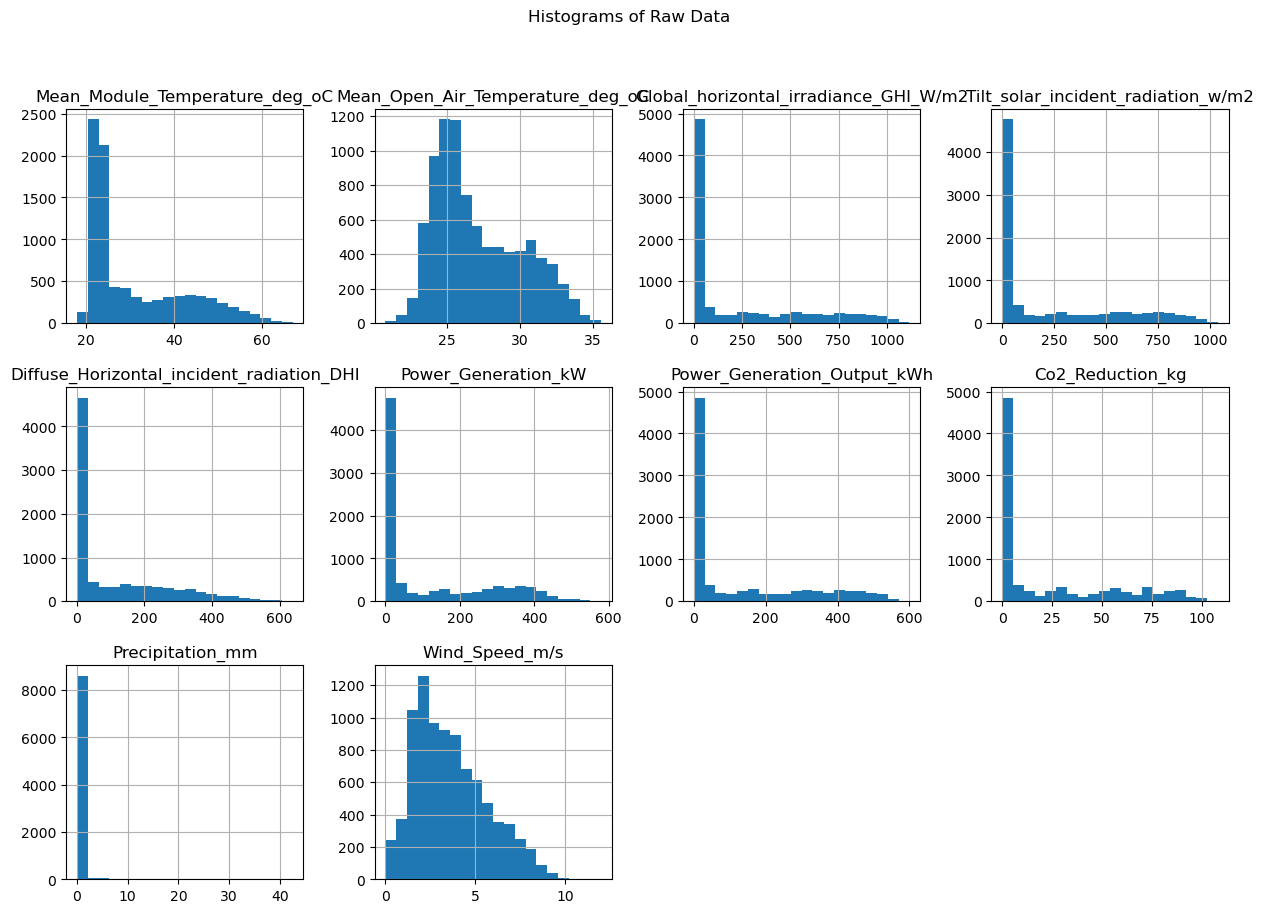

In [7]:
# Load Dataset

print("Dataset shape:", df.shape)
print("First 5 rows of raw data:")
print(df.head())

# Exclude the 'Date' column from the DataFrame for histogram plotting
df_filtered = df.drop(columns=["Date"])

axes = df_filtered.hist(bins=20, figsize=(15, 10), layout=(3, 4))

plt.suptitle("Histograms of Raw Data")
plt.show()

Feature Selection Methods

Pearson Correlations

Pearson Correlations with target:
Power_Generation_Output_kWh                  1.000000
Co2_Reduction_kg                             1.000000
Tilt_solar_incident_radiation_w/m2           0.987990
Global_horizontal_irradiance_GHI_W/m2        0.987150
Mean_Open_Air_Temperature_deg_oC             0.828087
Diffuse_Horizontal_incident_radiation_DHI    0.816170
Wind_Speed_m/s                               0.438189
Name: Power_Generation_Output_kWh, dtype: float64


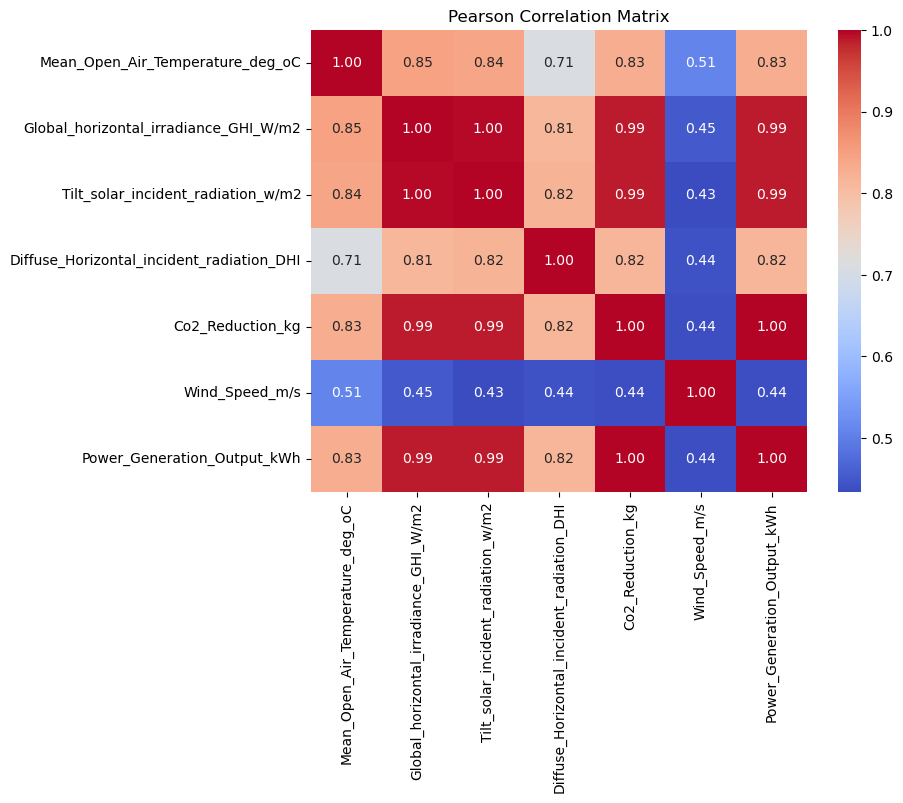

In [8]:
# Define features and target
features = [
    "Mean_Open_Air_Temperature_deg_oC",
    "Global_horizontal_irradiance_GHI_W/m2",
    "Tilt_solar_incident_radiation_w/m2",
    "Diffuse_Horizontal_incident_radiation_DHI",
    "Co2_Reduction_kg",
    "Wind_Speed_m/s"
]
target = "Power_Generation_Output_kWh"

# Create a subset DataFrame with the features and target
df_subset = df[features + [target]]

# Calculate Pearson correlation matrix
pearson_corr = df_subset.corr()

# Display correlation values with the target, sorted by absolute correlation
pearson_target_corr = pearson_corr[target].abs().sort_values(ascending=False)
print("Pearson Correlations with target:")
print(pearson_target_corr)

# Visualize the correlation matrix with a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(pearson_corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Pearson Correlation Matrix")
plt.show()


Spearman correlation

Spearman Correlations with target:
Power_Generation_Output_kWh                  1.000000
Co2_Reduction_kg                             1.000000
Global_horizontal_irradiance_GHI_W/m2        0.984346
Tilt_solar_incident_radiation_w/m2           0.981425
Diffuse_Horizontal_incident_radiation_DHI    0.939254
Mean_Open_Air_Temperature_deg_oC             0.773777
Wind_Speed_m/s                               0.397319
Name: Power_Generation_Output_kWh, dtype: float64


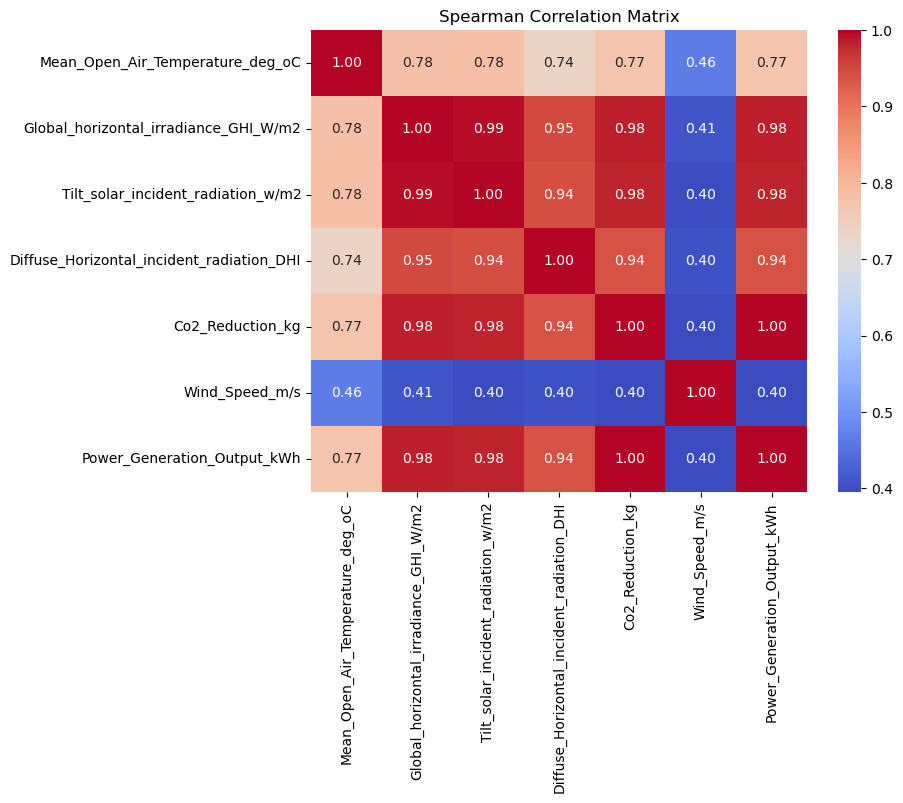

In [9]:
# Calculate Spearman correlation matrix
spearman_corr = df_subset.corr(method="spearman")

# Display correlation values with the target, sorted by absolute correlation
spearman_target_corr = spearman_corr[target].abs().sort_values(ascending=False)
print("Spearman Correlations with target:")
print(spearman_target_corr)

# Visualize the Spearman correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(spearman_corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Spearman Correlation Matrix")
plt.show()

Mutual Information

In [10]:
# Prepare the feature matrix X and target vector y
X = df_subset[features]
y = df_subset[target]

# Calculate mutual information between each feature and the target
mi = mutual_info_regression(X, y, random_state=42)
mi_series = pd.Series(mi, index=features).sort_values(ascending=False)

print("Mutual Information between features and target:")
print(mi_series)

Mutual Information between features and target:
Co2_Reduction_kg                             2.635520
Global_horizontal_irradiance_GHI_W/m2        1.748473
Tilt_solar_incident_radiation_w/m2           1.736783
Diffuse_Horizontal_incident_radiation_DHI    1.069143
Mean_Open_Air_Temperature_deg_oC             0.609011
Wind_Speed_m/s                               0.205579
dtype: float64


Selected Features

In [11]:
#  Keep ALL Hours

print("Keeping ALL hours (full 24-hour training).")
if "Time_hrs" in df.columns:
    print("Hour column distribution:")
    print(df["Time_hrs"].value_counts())


#  Select Features and Target

print("Selecting the most correlated features and the target variable.")
features = [
    "Global_horizontal_irradiance_GHI_W/m2",
    "Tilt_solar_incident_radiation_w/m2",
    "Diffuse_Horizontal_incident_radiation_DHI",
    "Co2_Reduction_kg",
    "Mean_Open_Air_Temperature_deg_oC"
]
target = "Power_Generation_Output_kWh"

# Extract input features and target values from the DataFrame.
input_features = df[features].values
output_feature = df[target].values.reshape(-1, 1)
print("Input features shape:", input_features.shape)
print("Target feature shape:", output_feature.shape)

Keeping ALL hours (full 24-hour training).
Hour column distribution:
01:00    365
02:00    365
23:00    365
22:00    365
21:00    365
20:00    365
19:00    365
18:00    365
17:00    365
16:00    365
15:00    365
14:00    365
13:00    365
12:00    365
11:00    365
10:00    365
09:00    365
08:00    365
07:00    365
06:00    365
05:00    365
04:00    365
03:00    365
24:00    365
Name: Time_hrs, dtype: int64
Selecting the most correlated features and the target variable.
Input features shape: (8760, 5)
Target feature shape: (8760, 1)


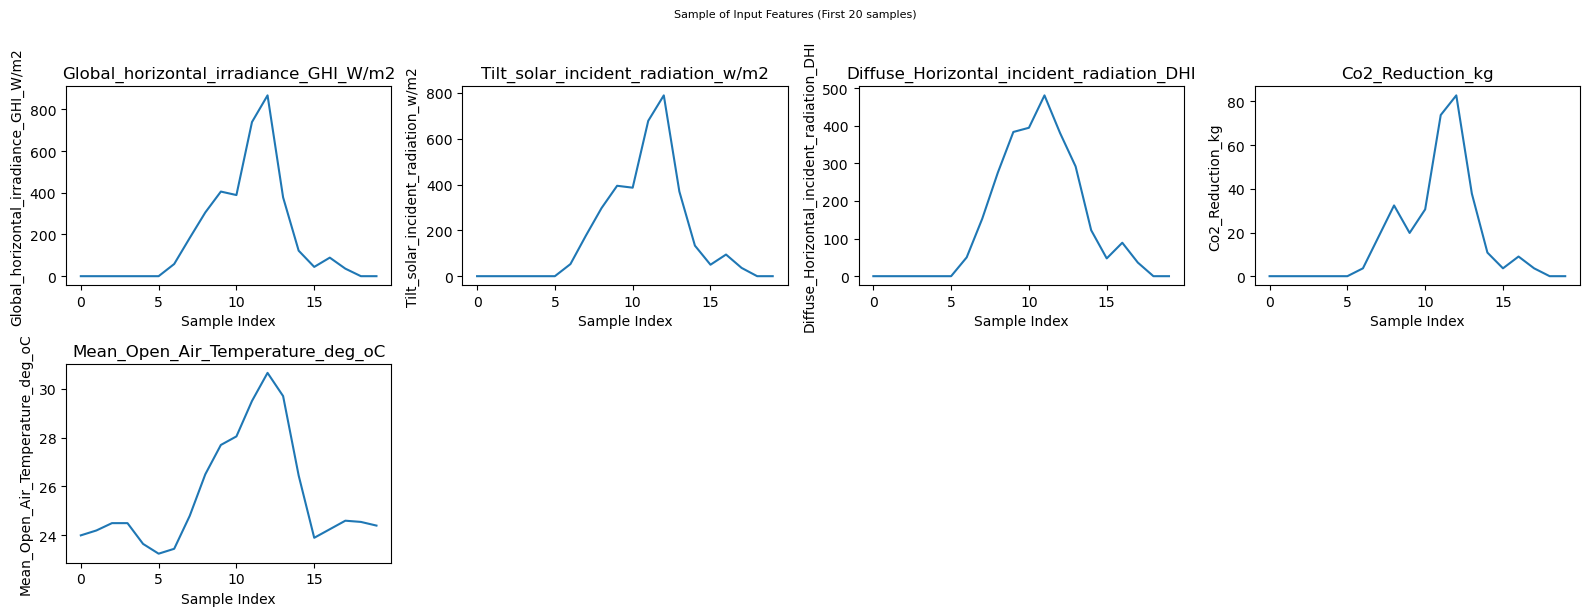

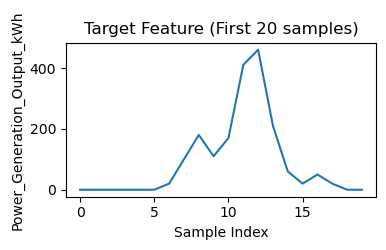

In [12]:
# Visualize the first 20 samples of each input feature in a 3x2 grid.
nrows, ncols = 2, 4
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 4, nrows * 3))
axes = axes.flatten()  

for i, feat in enumerate(features):
    axes[i].plot(input_features[:20, i])
    axes[i].set_title(feat)
    axes[i].set_xlabel("Sample Index")
    axes[i].set_ylabel(feat)


if len(features) < len(axes):
    for j in range(len(features), len(axes)):
        fig.delaxes(axes[j])

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.suptitle("Sample of Input Features (First 20 samples)", fontsize=8, y=1.02)
plt.show()

# Visualize the target variable.
plt.figure(figsize=(4, 2))
plt.plot(output_feature[:20])
plt.title("Target Feature (First 20 samples)")
plt.xlabel("Sample Index")
plt.ylabel(target)
plt.show()

Outlier Removal

Removing outliers using Isolation Forest on combined inputs and target.
Combined data shape before outlier removal: (8760, 6)
Data shape after outlier removal: (8584, 5) (8584, 1)


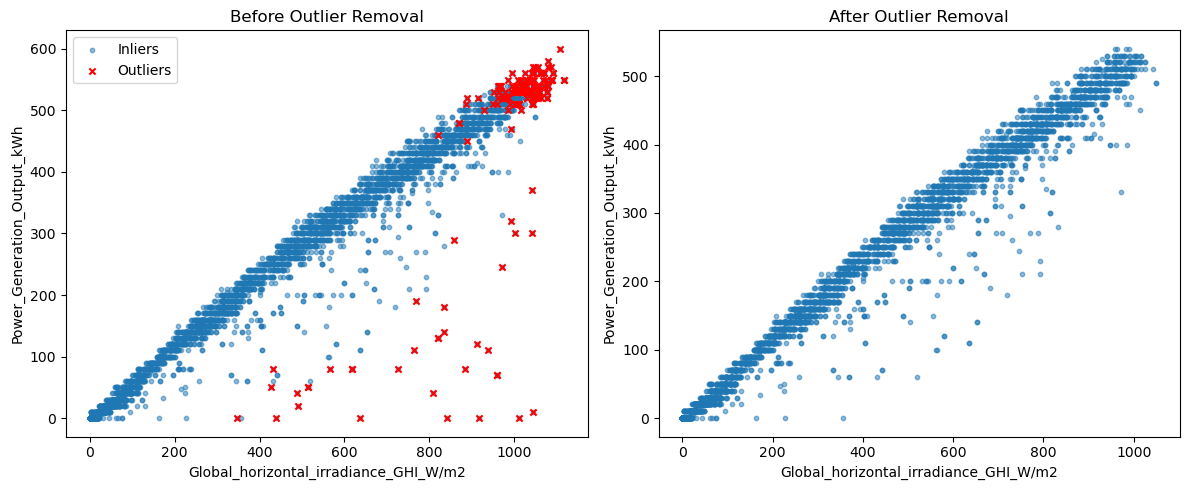

In [12]:
# Remove Outliers using Isolation Forest

print("Removing outliers using Isolation Forest on combined inputs and target.")

# Combine inputs and target into one array.
combined_data = np.hstack((input_features, output_feature))
print("Combined data shape before outlier removal:", combined_data.shape)

# Instantiate IsolationForest with 2% expected contamination.
iso_forest = IsolationForest(contamination=0.02, random_state=42)
# Fit the model and predict outliers (-1 are outliers, 1 are inliers).
outliers = iso_forest.fit_predict(combined_data)
mask = outliers == 1  # Keep only inliers (rows with label 1)

# Filter out the outliers from both inputs and target.
input_features = input_features[mask]
output_feature = output_feature[mask]
print("Data shape after outlier removal:", input_features.shape, output_feature.shape)

# Visualize the effect of outlier removal on the first feature vs. target.
plt.figure(figsize=(12, 5))

# Plot Before Outlier Removal 
plt.subplot(1, 2, 1)
plt.scatter(combined_data[:, 0], combined_data[:, -1], s=10, alpha=0.5, label='Inliers')
# Identify outlier indices (where outliers == -1)
outlier_indices = np.where(outliers == -1)[0]
plt.scatter(combined_data[outlier_indices, 0], combined_data[outlier_indices, -1],
            s=20, color='r', marker='x', label='Outliers')
plt.title("Before Outlier Removal")
plt.xlabel(features[0])
plt.ylabel(target)
plt.legend()

# Plot After Outlier Removal
plt.subplot(1, 2, 2)
plt.scatter(input_features[:, 0], output_feature, s=10, alpha=0.5)
plt.title("After Outlier Removal")
plt.xlabel(features[0])
plt.ylabel(target)
plt.tight_layout()
plt.show()


Feature Engineering

Selection of Appropriate Feature for Feature Engineering

Feature: Global_horizontal_irradiance_GHI_W/m2
Top 3 lags (lag, ACF): [(1, 0.9106598842849747), (24, 0.8997606883652293), (23, 0.8450962827532217)]


<Figure size 800x400 with 0 Axes>

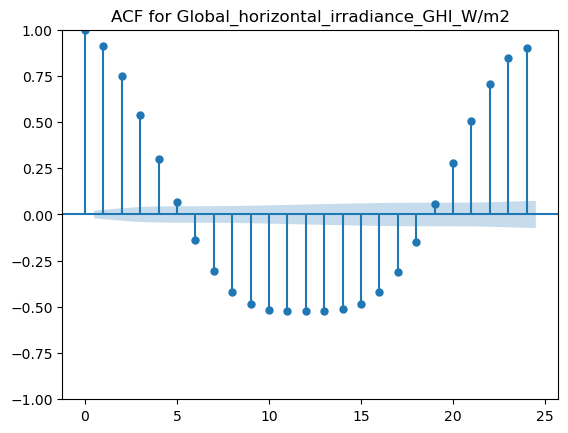

Feature: Tilt_solar_incident_radiation_w/m2
Top 3 lags (lag, ACF): [(1, 0.9118473016563211), (24, 0.9025030603474377), (23, 0.8485739657840893)]


<Figure size 800x400 with 0 Axes>

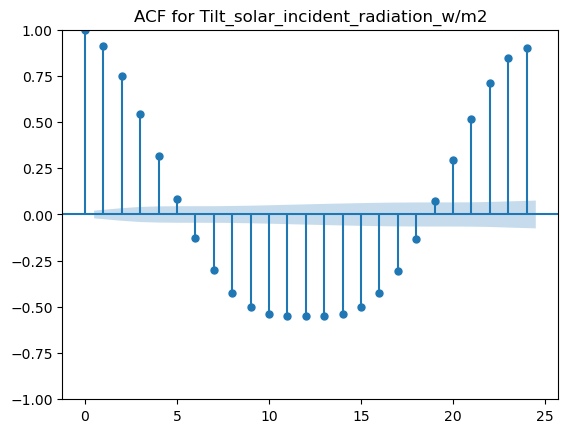

Feature: Diffuse_Horizontal_incident_radiation_DHI
Top 3 lags (lag, ACF): [(1, 0.902701423863455), (24, 0.8583370593247344), (23, 0.8088803704524379)]


<Figure size 800x400 with 0 Axes>

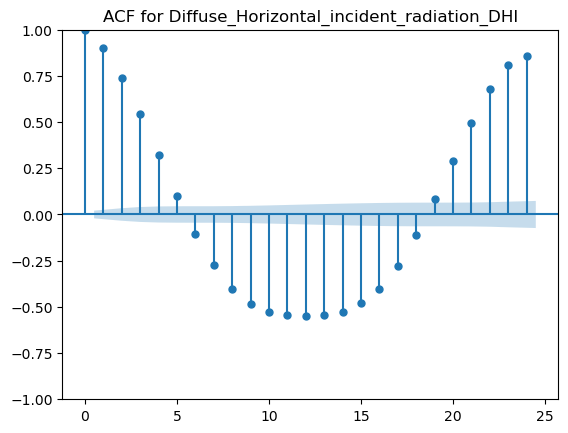

Feature: Co2_Reduction_kg
Top 3 lags (lag, ACF): [(1, 0.9021608719963062), (24, 0.8894971227483177), (23, 0.8345500005284873)]


<Figure size 800x400 with 0 Axes>

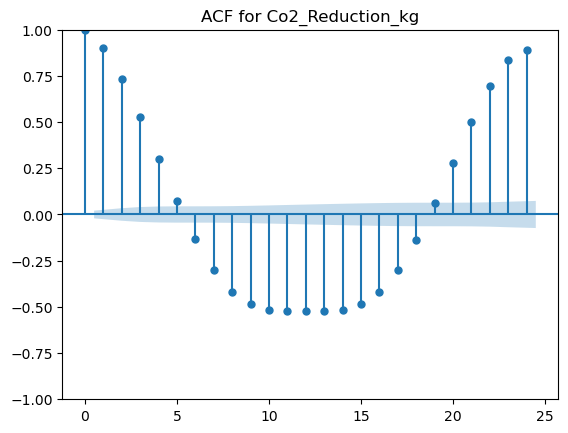

Feature: Mean_Open_Air_Temperature_deg_oC
Top 3 lags (lag, ACF): [(1, 0.9494447226924412), (24, 0.8808373866826475), (23, 0.8445421250498698)]


<Figure size 800x400 with 0 Axes>

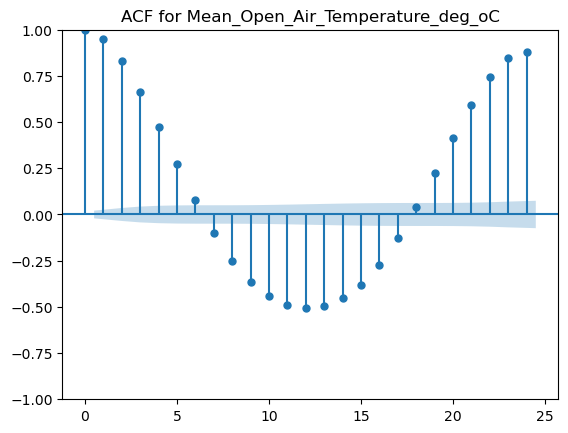


Selected best lag features for each climate variable:
Global_horizontal_irradiance_GHI_W/m2: [(1, 0.9106598842849747), (24, 0.8997606883652293), (23, 0.8450962827532217)]
Tilt_solar_incident_radiation_w/m2: [(1, 0.9118473016563211), (24, 0.9025030603474377), (23, 0.8485739657840893)]
Diffuse_Horizontal_incident_radiation_DHI: [(1, 0.902701423863455), (24, 0.8583370593247344), (23, 0.8088803704524379)]
Co2_Reduction_kg: [(1, 0.9021608719963062), (24, 0.8894971227483177), (23, 0.8345500005284873)]
Mean_Open_Air_Temperature_deg_oC: [(1, 0.9494447226924412), (24, 0.8808373866826475), (23, 0.8445421250498698)]


In [13]:
# Define the number of lags you want to compute
nlags = 24

# Dictionary to store best lag features for each climate feature
lag_features = {}

# Loop through each feature, compute its autocorrelation, and select top lags
for feature in features:
    series = df[feature]
    
    # Compute autocorrelation values up to nlags lags
    acf_vals = acf(series, nlags=nlags, fft=True)
    lags = np.arange(0, nlags+1)
    
    # Combine lags and acf values into pairs 
    lag_acf_pairs = list(zip(lags[1:], acf_vals[1:]))
    
    # Sort by absolute autocorrelation value in descending order
    lag_acf_pairs_sorted = sorted(lag_acf_pairs, key=lambda x: abs(x[1]), reverse=True)
    
    # Select the top 3 lags 
    best_lags = lag_acf_pairs_sorted[:3]
    lag_features[feature] = best_lags
    
    print(f"Feature: {feature}")
    print("Top 3 lags (lag, ACF):", best_lags)
    
    # Plot the ACF for visualization
    plt.figure(figsize=(8, 4))
    plot_acf(series, lags=nlags, title=f"ACF for {feature}")
    plt.show()


print("\nSelected best lag features for each climate variable:")
for feat, lags in lag_features.items():
    print(f"{feat}: {lags}")

Lag Features Creation

Creating lag features for previous hour and previous day.
First 10 rows after adding lag features:
   Global_horizontal_irradiance_GHI_W/m2  Tilt_solar_incident_radiation_w/m2  \
0                               0.000000                            0.000000   
1                               0.000000                            0.000000   
2                               0.000000                            0.000000   
3                               0.000000                            0.000000   
4                               0.000000                            0.000000   
5                               0.000000                            0.000000   
6                              58.333333                           52.777778   
7                             183.333333                          177.777778   
8                             305.555556                          297.222222   
9                             405.555556                          394.444444   

   Diffuse_Horizonta

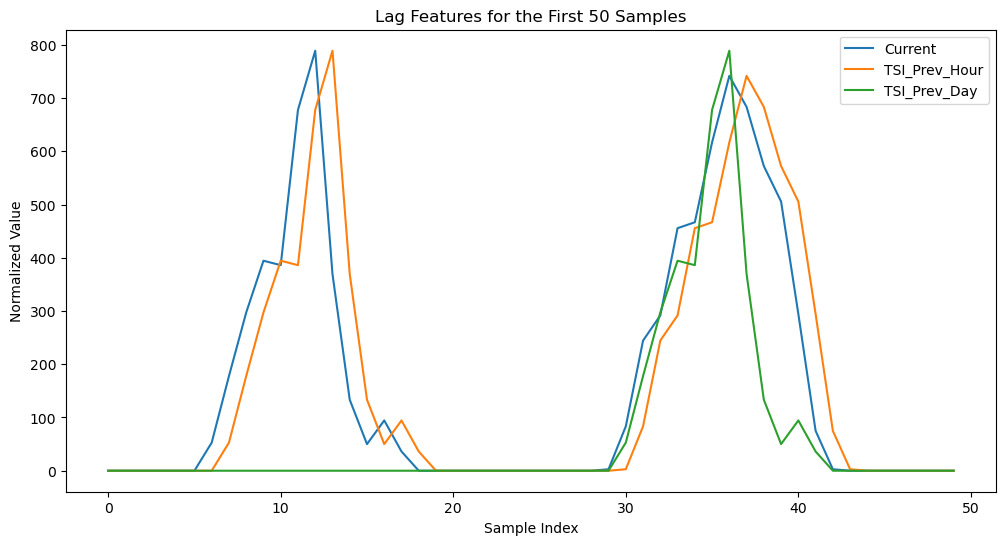

In [14]:
# Create Lag Features (Prev Hour & Prev Day)

print("Creating lag features for previous hour and previous day.")

# Create a DataFrame from the scaled inputs with column names.
df_lagged = pd.DataFrame(input_features, columns=features)
# Create a lagged feature representing the previous hour's value.
df_lagged["TSI_Prev_Hour"] = df_lagged["Tilt_solar_incident_radiation_w/m2"].shift(1).fillna(0)
# Create a lagged feature representing the value from 24 hours earlier.
df_lagged["TSI_Prev_Day"] = df_lagged["Tilt_solar_incident_radiation_w/m2"].shift(24).fillna(0)
print("First 10 rows after adding lag features:")
print(df_lagged.head(10))

# Visualize the current feature along with its lagged versions (first 50 samples).
plt.figure(figsize=(12, 6))
plt.plot(df_lagged["Tilt_solar_incident_radiation_w/m2"][:50], label="Current")
plt.plot(df_lagged["TSI_Prev_Hour"][:50], label="TSI_Prev_Hour")
plt.plot(df_lagged["TSI_Prev_Day"][:50], label="TSI_Prev_Day")
plt.title("Lag Features for the First 50 Samples")
plt.xlabel("Sample Index")
plt.ylabel("Normalized Value")
plt.legend()
plt.show()

# Convert the DataFrame back to a NumPy array.
input_features = df_lagged.values

Data Normalization

Normalizing data using MinMaxScaler.
Scaled inputs shape: (8584, 7)
Scaled output shape: (8584, 1)


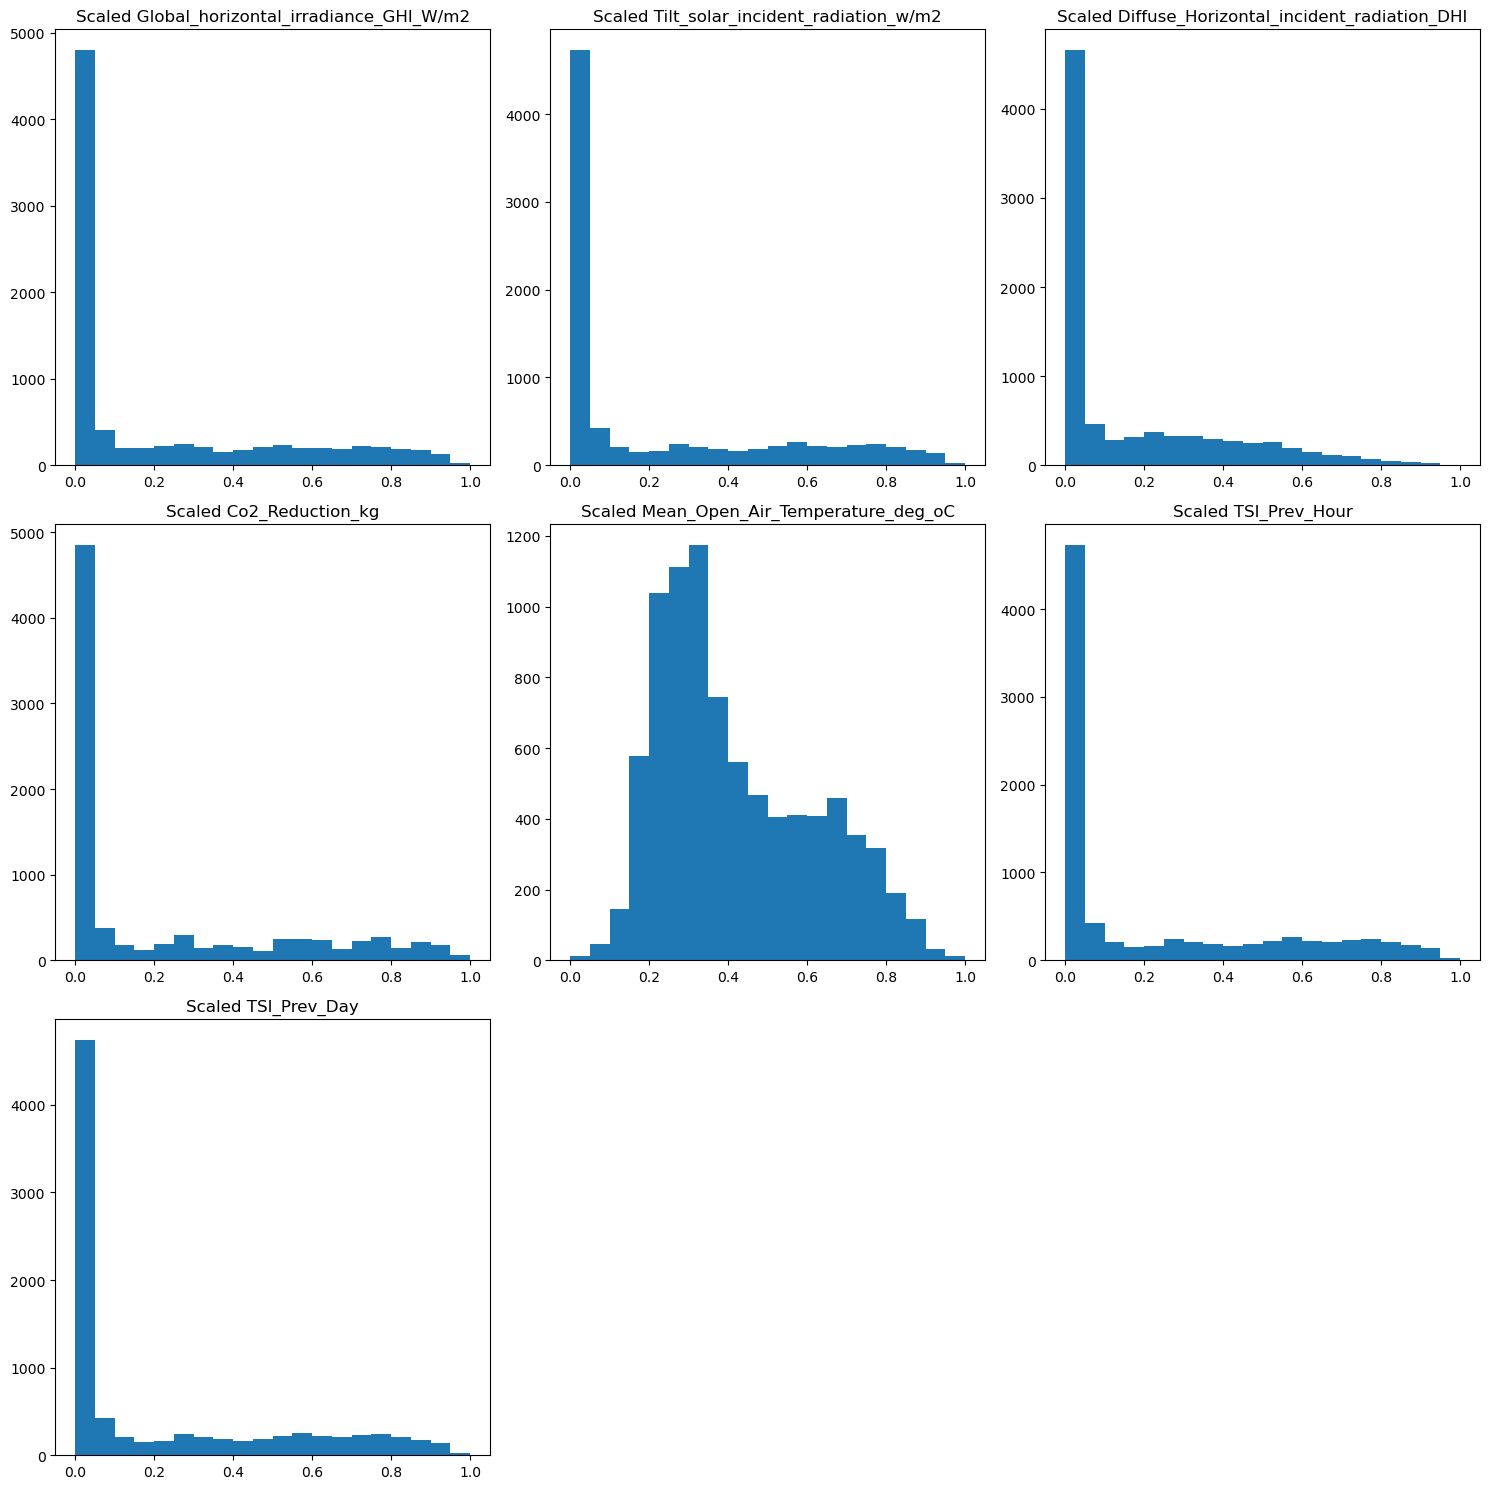

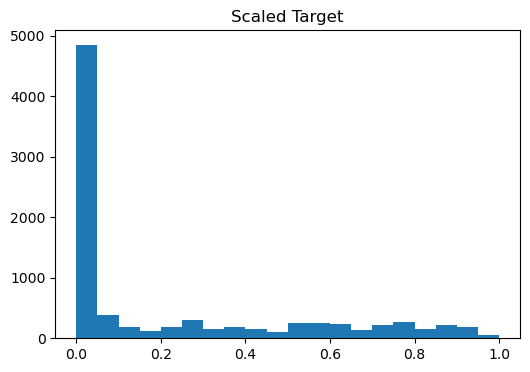

In [15]:
#  Normalize Data

print("Normalizing data using MinMaxScaler.")

# Initialize scalers for inputs and target.
scaler_inputs = MinMaxScaler()
scaler_output = MinMaxScaler()

# Scale (normalize) input features and target to the range [0, 1].
scaled_inputs = scaler_inputs.fit_transform(input_features)
scaled_output = scaler_output.fit_transform(output_feature)
print("Scaled inputs shape:", scaled_inputs.shape)
print("Scaled output shape:", scaled_output.shape)

feature_names = [
    "Global_horizontal_irradiance_GHI_W/m2",
    "Tilt_solar_incident_radiation_w/m2",
    "Diffuse_Horizontal_incident_radiation_DHI",
    "Co2_Reduction_kg",
    "Mean_Open_Air_Temperature_deg_oC",
    "TSI_Prev_Hour",  
    "TSI_Prev_Day"   
]

# Plot histograms of scaled input features using the defined feature names.
num_features = scaled_inputs.shape[1]  
nrows = 3
ncols = math.ceil(num_features / nrows)  

plt.figure(figsize=(ncols * 5, nrows * 5))
for i in range(num_features):
    plt.subplot(nrows, ncols, i + 1)
    plt.hist(scaled_inputs[:, i], bins=20)
    plt.title(f"Scaled {feature_names[i]}")
plt.tight_layout()
plt.show()

# Plot histogram for scaled target.
plt.figure(figsize=(6, 4))
plt.hist(scaled_output, bins=20)
plt.title("Scaled Target")
plt.show()


Data Denoising

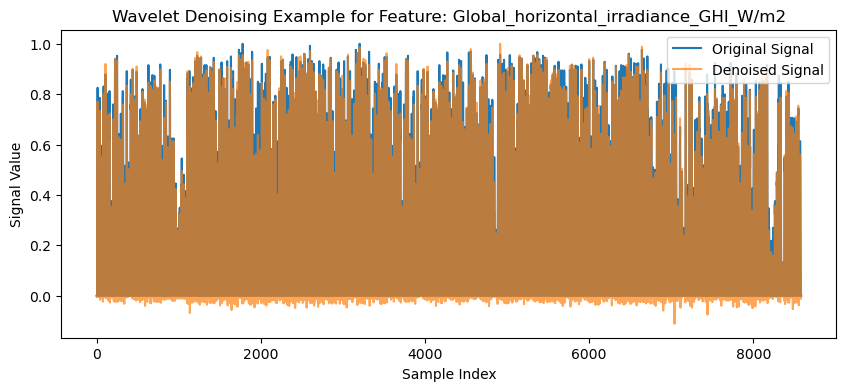

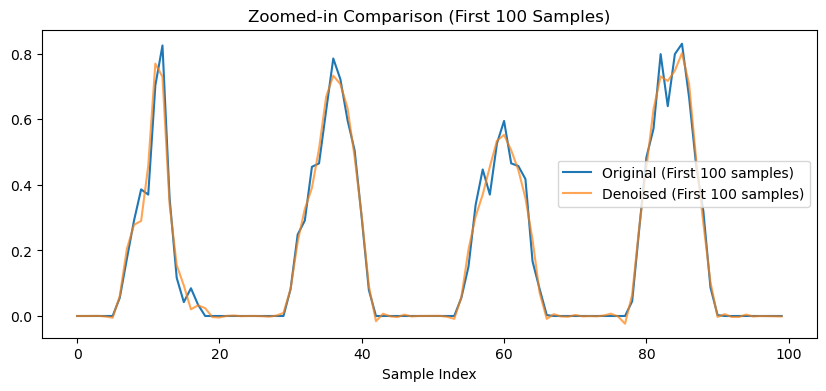

In [16]:
# Using denoising function
def wavelet_denoising(signal):
    """
    Applies wavelet denoising on a 1D signal using Daubechies 4 wavelet.
    - Decomposes the signal to level 1.
    - Zeroes out detail coefficients (noise).
    - Reconstructs the signal using the approximation coefficients.
    """
    coeffs = pywt.wavedec(signal, 'db4', level=1)  # Decompose signal
    coeffs[1:] = [np.zeros_like(c) for c in coeffs[1:]]  # Remove detail coefficients
    return pywt.waverec(coeffs, 'db4')[:len(signal)]  # Reconstruct and match length

example_signal = scaled_inputs[:, 0]
denoised_signal = wavelet_denoising(example_signal)

# Plot the full signal for visual inspection
plt.figure(figsize=(10, 4))
plt.plot(example_signal, label="Original Signal")
plt.plot(denoised_signal, label="Denoised Signal", alpha=0.7)
plt.title("Wavelet Denoising Example for Feature: " + features[0])
plt.xlabel("Sample Index")
plt.ylabel("Signal Value")
plt.legend()
plt.show()

# Zoom in on the first 100 samples for finer detail comparison
plt.figure(figsize=(10, 4))
plt.plot(example_signal[:100], label="Original (First 100 samples)")
plt.plot(denoised_signal[:100], label="Denoised (First 100 samples)", alpha=0.7)
plt.title("Zoomed-in Comparison (First 100 Samples)")
plt.xlabel("Sample Index")
plt.legend()
plt.show()


Evaluation of Denoising

Frequency domain analysis using FFT

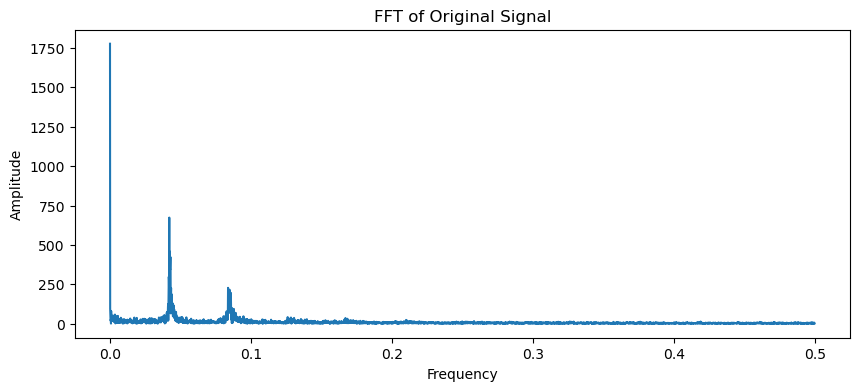

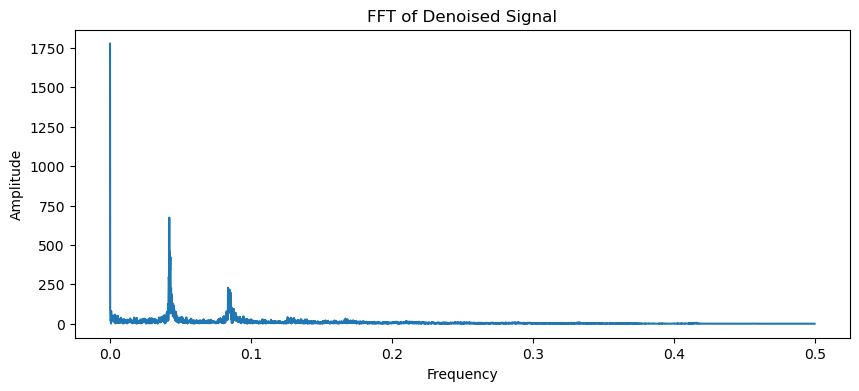

In [17]:
def plot_fft(signal, title, sample_rate=1.0):
    N = len(signal)
    yf = fft(signal)
    xf = fftfreq(N, 1 / sample_rate)
    plt.figure(figsize=(10, 4))
    plt.plot(xf[:N//2], np.abs(yf[:N//2]))
    plt.title(title)
    plt.xlabel("Frequency")
    plt.ylabel("Amplitude")
    plt.show()

plot_fft(example_signal, "FFT of Original Signal")
plot_fft(denoised_signal, "FFT of Denoised Signal")


Autocorrelation Analysis

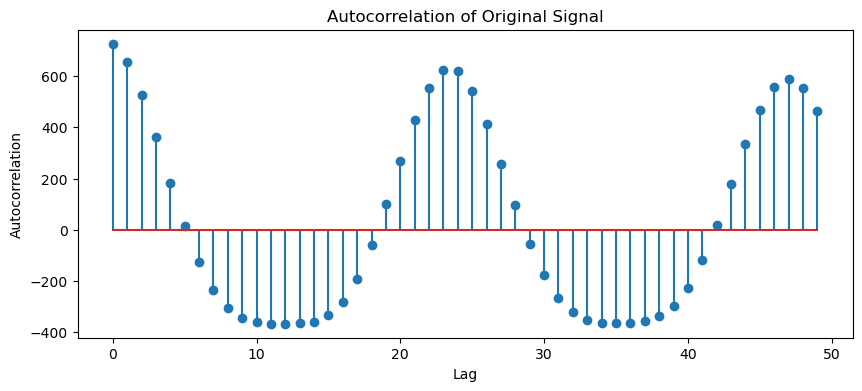

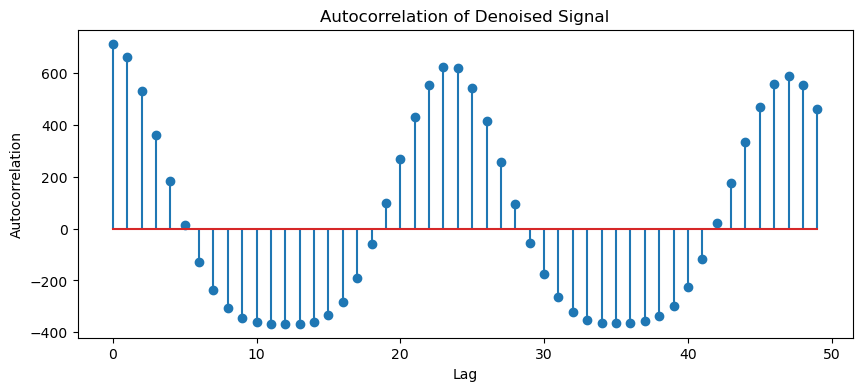

In [18]:
def plot_autocorrelation(signal, title, max_lag=50):
    signal_centered = signal - np.mean(signal)
    autocorr = np.correlate(signal_centered, signal_centered, mode='full')
    mid = len(autocorr) // 2
    lags = np.arange(0, max_lag)
    plt.figure(figsize=(10, 4))
    plt.stem(lags, autocorr[mid:mid+max_lag], use_line_collection=True)
    plt.title(title)
    plt.xlabel("Lag")
    plt.ylabel("Autocorrelation")
    plt.show()

plot_autocorrelation(example_signal, "Autocorrelation of Original Signal")
plot_autocorrelation(denoised_signal, "Autocorrelation of Denoised Signal")


Variance-based Evaluation

In [19]:
var_original = np.var(example_signal)
var_denoised = np.var(denoised_signal)
removed_noise = example_signal - denoised_signal
var_noise = np.var(removed_noise)

print("Variance of Original Signal:", var_original)
print("Variance of Denoised Signal:", var_denoised)
print("Variance of Removed Noise:", var_noise)


Variance of Original Signal: 0.08468240369828019
Variance of Denoised Signal: 0.08319460266224814
Variance of Removed Noise: 0.0014878010360320501


In [20]:
# Apply denoising to all input features.
for i in range(input_features.shape[1]):
    scaled_inputs[:, i] = wavelet_denoising(scaled_inputs[:, i])

# Apply denoising to the target, then clip its values to remain within [0, 1].
denoised_output = wavelet_denoising(scaled_output.flatten())
scaled_output = np.clip(denoised_output, 0, 1).reshape(-1, 1)

Dataset Stacking and Structuring

In [21]:
# Stack Processed Features and Output

print("Stacking processed features and target output together.")

# Combine the processed input features and the target into one array.
tensor_data_normalized = np.column_stack((scaled_inputs, scaled_output))
print("Final stacked data shape:", tensor_data_normalized.shape)
print("First 5 rows of the final stacked data:")
print(tensor_data_normalized[:5])

Stacking processed features and target output together.
Final stacked data shape: (8584, 8)
First 5 rows of the final stacked data:
[[-5.41526381e-06 -3.49863348e-05  9.05195679e-06 -1.71537590e-04
   2.16858745e-01 -1.31780451e-04  0.00000000e+00  0.00000000e+00]
 [-1.68031926e-05 -1.08560200e-04  2.80876017e-05 -5.32269389e-04
   2.43298813e-01 -4.08905711e-04  0.00000000e+00  0.00000000e+00]
 [ 9.34790282e-05  1.88130753e-04  1.47615967e-04  1.27799507e-03
   2.48001139e-01  6.57876606e-04  0.00000000e+00  1.27799507e-03]
 [ 3.36731702e-04  8.85294519e-04  3.80025885e-04  5.44396687e-03
   2.39610605e-01  3.17712582e-03  0.00000000e+00  5.44396687e-03]
 [-1.45713340e-03 -1.45364095e-03 -1.28118315e-03 -3.26978333e-03
   2.12898677e-01 -1.03372092e-03  0.00000000e+00  0.00000000e+00]]


In [22]:
# Split dataset (80% train, 10% validation, 10% test)
num_samples = tensor_data_normalized.shape[0]
num_train = int(0.8 * num_samples)
num_valid = int(0.1 * num_samples)
num_test = num_samples - num_train - num_valid

print("Total samples:", num_samples)
print("Training samples:", num_train)
print("Validation samples:", num_valid)
print("Test samples:", num_test)

train_data = tensor_data_normalized[:num_train].T
validation_data = tensor_data_normalized[num_train:num_train + num_valid].T
testing_data = tensor_data_normalized[num_train + num_valid:].T

print("\nAfter transpose:")
print("Train data shape:", train_data.shape)
print("Validation data shape:", validation_data.shape)
print("Test data shape:", testing_data.shape)

# Define sequence length (`memdepth`)
memdepth = 5  # Sequence length is set to 5

# Create sequences for the transformer
def create_sequences(data, memdepth):
    sequences = []
    for i in range(data.shape[1] - memdepth):
        X = data[:-1, i:i+memdepth].T  # X shape: (memdepth, 5)
        y = data[-1, i+memdepth]       # scalar target
        sequences.append((X, y))
    return sequences

train_sequences = create_sequences(train_data, memdepth)
val_sequences = create_sequences(validation_data, memdepth)
test_sequences = create_sequences(testing_data, memdepth)

print("\nNumber of sequences:")
print("Training sequences:", len(train_sequences))
print("Validation sequences:", len(val_sequences))
print("Test sequences:", len(test_sequences))

# Convert sequences to PyTorch tensors
train_X = torch.Tensor([seq[0] for seq in train_sequences])  # shape: (N_train, memdepth, 7)
train_y = torch.Tensor([seq[1] for seq in train_sequences]).view(-1, 1)
val_X = torch.Tensor([seq[0] for seq in val_sequences])
val_y = torch.Tensor([seq[1] for seq in val_sequences]).view(-1, 1)
test_X = torch.Tensor([seq[0] for seq in test_sequences])
test_y = torch.Tensor([seq[1] for seq in test_sequences]).view(-1, 1)

print("\nAfter converting to PyTorch tensors:")
print("train_X shape:", train_X.shape)
print("train_y shape:", train_y.shape)
print("val_X shape:", val_X.shape)
print("val_y shape:", val_y.shape)
print("test_X shape:", test_X.shape)
print("test_y shape:", test_y.shape)

Total samples: 8584
Training samples: 6867
Validation samples: 858
Test samples: 859

After transpose:
Train data shape: (8, 6867)
Validation data shape: (8, 858)
Test data shape: (8, 859)

Number of sequences:
Training sequences: 6862
Validation sequences: 853
Test sequences: 854

After converting to PyTorch tensors:
train_X shape: torch.Size([6862, 5, 7])
train_y shape: torch.Size([6862, 1])
val_X shape: torch.Size([853, 5, 7])
val_y shape: torch.Size([853, 1])
test_X shape: torch.Size([854, 5, 7])
test_y shape: torch.Size([854, 1])


Novel Transformer Model Architecture

In [23]:

# Transformer Model Components


def clones(module, N):
    """Produce N identical layers."""
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

class Encoder(nn.Module):
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        if N > 1:
            self.norm2 = LayerNorm(layer.size)
 
    def forward(self, x, mask):
        for idx, layer in enumerate(self.layers, start=1):
            x = layer(x, mask)
            if idx == len(self.layers)//2 and len(self.layers) > 1:
                x = self.norm2(x)
        return self.norm(x)

class SublayerConnection(nn.Module):
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout) 
    def forward(self, x, sublayer):
        return x + self.dropout(sublayer(self.norm(x)))

class EncoderLayer(nn.Module):
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size 
    def forward(self, x, mask):
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        return self.sublayer[1](x, self.feed_forward)

class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
 
    def forward(self, query, key, value, mask=None):
        nbatches = query.size(0)
        query, key, value = [
            l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
            for l, x in zip(self.linears, (query, key, value))
        ]
        x, self.attn = self.attention(query, key, value, mask=mask)
        x = x.transpose(1, 2).contiguous().view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x) 

    def attention(self, query, key, value, mask=None):
        d_k = query.size(-1)
        scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)
        if mask is not None:
            scores = scores.masked_fill(mask, -1e9)
        p_attn = F.softmax(scores, dim=-1)
        if self.dropout is not None:
            p_attn = self.dropout(p_attn)
        return torch.matmul(p_attn, value), p_attn

# Modified: Replace FC layers with two 1-D CNNs in the Feed Forward module.
class ConvPositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0):
        super(ConvPositionwiseFeedForward, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=d_model, out_channels=d_ff, kernel_size=3, padding='same')
        self.conv2 = nn.Conv1d(in_channels=d_ff, out_channels=d_model, kernel_size=3, padding='same')
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # x shape: (batch_size, seq_len, d_model) -> transpose to (batch_size, d_model, seq_len)
        x = x.transpose(1, 2)
        x = self.conv1(x)  # (batch_size, d_ff, seq_len)
        x = F.gelu(x)
        x = self.dropout(x)
        x = self.conv2(x)  # (batch_size, d_model, seq_len)
        x = x.transpose(1, 2)  # (batch_size, seq_len, d_model)
        return x

class neuralNet(nn.Module):
    def __init__(self,
                 in_features,
                 d_model,
                 h,
                 seq_len,
                 num_dec,
                 fn1,
                 dropout=0.1):
        super(neuralNet, self).__init__()
        c = copy.deepcopy
        attn = MultiHeadedAttention(h, d_model, dropout=dropout)
        ff = ConvPositionwiseFeedForward(d_model, d_model * 4, dropout)
        self.d_model = d_model
        self.seq_len = seq_len
        # Embedding and positional encoding: map input features to model dimension.
        self.embedding_pe = nn.Linear(in_features, d_model)
        # Transformer encoder (stacked layers)
        self.enocderTF = Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), num_dec)
        # Fully connected layers after flattening the encoder output.
        self.fc1 = nn.Linear(d_model * seq_len, fn1)
        # Final output layer producing a single forecast value.
        self.fc_out = nn.Linear(fn1, 1)
 
    def forward(self, x):
        # x shape: (batch_size, seq_len, in_features)
        x = self.embedding_pe(x) # => (batch_size, seq_len, d_model)
        x = F.gelu(self.enocderTF(x, mask=None))
        x = F.gelu(self.fc1(x.view(-1, self.d_model * self.seq_len)))
        out = self.fc_out(x)  # => (batch_size, 1)
        out = F.softplus(out)
        return out

In [24]:
# Instantiate & Train Transformer

# Hyperparameters
in_features = 7     # 5 original + 2 lag features
d_model = 16        # Model dimension
seq_len = memdepth  # 5
h = 4               # Number of attention heads
num_dec = 1         # Number of encoder layers
fn1 = 32            # Fully connected layer size after encoder
dropout = 0.2

network = neuralNet(in_features, d_model, h, seq_len, num_dec, fn1, dropout)
print(network)

neuralNet(
  (embedding_pe): Linear(in_features=7, out_features=16, bias=True)
  (enocderTF): Encoder(
    (layers): ModuleList(
      (0): EncoderLayer(
        (self_attn): MultiHeadedAttention(
          (linears): ModuleList(
            (0-3): 4 x Linear(in_features=16, out_features=16, bias=True)
          )
          (dropout): Dropout(p=0.2, inplace=False)
        )
        (feed_forward): ConvPositionwiseFeedForward(
          (conv1): Conv1d(16, 64, kernel_size=(3,), stride=(1,), padding=same)
          (conv2): Conv1d(64, 16, kernel_size=(3,), stride=(1,), padding=same)
          (dropout): Dropout(p=0.2, inplace=False)
        )
        (sublayer): ModuleList(
          (0-1): 2 x SublayerConnection(
            (norm): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
            (dropout): Dropout(p=0.2, inplace=False)
          )
        )
      )
    )
    (norm): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
  )
  (fc1): Linear(in_features=80, out_features=32

Model Training

Epoch 0: Train Loss = 0.0306, Validation Loss = 0.0068
Epoch 1: Train Loss = 0.0073, Validation Loss = 0.0094
Epoch 2: Train Loss = 0.0059, Validation Loss = 0.0045
Epoch 3: Train Loss = 0.0049, Validation Loss = 0.0042
Epoch 4: Train Loss = 0.0043, Validation Loss = 0.0039
Epoch 5: Train Loss = 0.0039, Validation Loss = 0.0033
Epoch 6: Train Loss = 0.0036, Validation Loss = 0.0040
Epoch 7: Train Loss = 0.0033, Validation Loss = 0.0036
Epoch 8: Train Loss = 0.0033, Validation Loss = 0.0026
Epoch 9: Train Loss = 0.0029, Validation Loss = 0.0029
Epoch 10: Train Loss = 0.0028, Validation Loss = 0.0026
Epoch 11: Train Loss = 0.0026, Validation Loss = 0.0025
Epoch 12: Train Loss = 0.0024, Validation Loss = 0.0023
Epoch 13: Train Loss = 0.0024, Validation Loss = 0.0022
Epoch 14: Train Loss = 0.0024, Validation Loss = 0.0021
Epoch 15: Train Loss = 0.0023, Validation Loss = 0.0021
Epoch 16: Train Loss = 0.0024, Validation Loss = 0.0023
Epoch 17: Train Loss = 0.0021, Validation Loss = 0.0020
Ep

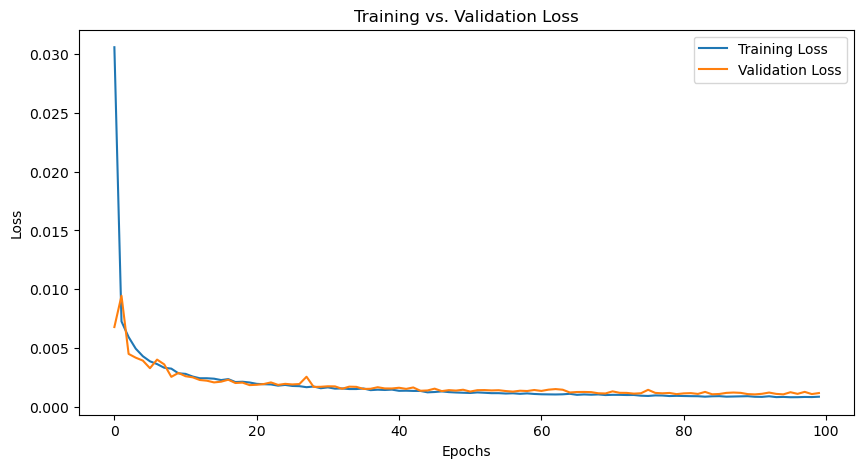

In [25]:
criterion = nn.MSELoss()
optimizer = optim.Adam(network.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(TensorDataset(train_X, train_y), batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(TensorDataset(val_X, val_y), batch_size=batch_size, shuffle=False)

max_epochs = 100
best_val_loss = float('inf')
patience_counter = 0
train_losses, val_losses = [], []

for epoch in range(max_epochs):
    network.train()
    epoch_train_loss = 0
    for inp, out in train_loader:
        optimizer.zero_grad()
        pred = network(inp)
        loss = criterion(pred, out)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
    epoch_train_loss /= len(train_loader)
    train_losses.append(epoch_train_loss)
    
    network.eval()
    epoch_val_loss = 0
    with torch.no_grad():
        for inp, out in val_loader:
            pred = network(inp)
            epoch_val_loss += criterion(pred, out).item()
    epoch_val_loss /= len(val_loader)
    val_losses.append(epoch_val_loss)
    
    print(f"Epoch {epoch}: Train Loss = {epoch_train_loss:.4f}, Validation Loss = {epoch_val_loss:.4f}")
    
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        patience_counter = 0
        torch.save(network.state_dict(), "Test_Transformer_best_model_modified.pth")
    else:
        patience_counter += 1
    if patience_counter >= 100:
        print("Early stopping triggered.")
        break

# Plot Loss Graph
plt.figure(figsize=(10,5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs. Validation Loss")
plt.legend()
plt.show()

Model Evaluation

In [26]:
# Evaluate Model Performance


# Load the best model
network.load_state_dict(torch.load("Test_Transformer_best_model_modified.pth"))
network.eval()

# Calculate Mertices
with torch.no_grad():
    train_pred = network(train_X).detach().numpy()
    train_true = train_y.numpy()
    test_pred = network(test_X).detach().numpy()
    test_true = test_y.numpy()
    
train_pred_real = scaler_output.inverse_transform(train_pred)
train_true_real = scaler_output.inverse_transform(train_true)
test_pred_real = scaler_output.inverse_transform(test_pred)
test_true_real = scaler_output.inverse_transform(test_true)


train_rmse = np.sqrt(mean_squared_error(train_true_real, train_pred_real))
test_rmse = np.sqrt(mean_squared_error(test_true_real, test_pred_real))

train_r2 = r2_score(train_true_real, train_pred_real)
test_r2 = r2_score(test_true_real, test_pred_real)

train_mae = mean_absolute_error(train_true_real, train_pred_real)
test_mae = mean_absolute_error(test_true_real, test_pred_real)

train_bias = np.mean(train_pred_real - train_true_real)
test_bias = np.mean(test_pred_real - test_true_real)

print("---RMSE---")
print("Train RMSE (real scale):", train_rmse)
print("Test RMSE (real scale):", test_rmse)

print("---R²---")
print("Train R²:", train_r2)
print("Test R²:", test_r2)

print("---MAE---")
print("Train MAE (real scale):", train_mae)
print("Test MAE (real scale):", test_mae)

print("---Bias---")
print("Train Bias (real scale):", train_bias)
print("Test Bias (real scale):", test_bias)

---RMSE---
Train RMSE (real scale): 13.288967
Test RMSE (real scale): 14.208618
---R²---
Train R²: 0.9934553760255217
Test R²: 0.991097537986746
---MAE---
Train MAE (real scale): 7.7767205
Test MAE (real scale): 8.296436
---Bias---
Train Bias (real scale): 1.8450701
Test Bias (real scale): 1.9187169


In [27]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

total_params = count_parameters(network)
print("Total trainable parameters:", total_params)

Total trainable parameters: 10161


Actuals vs Forecast Results Plots

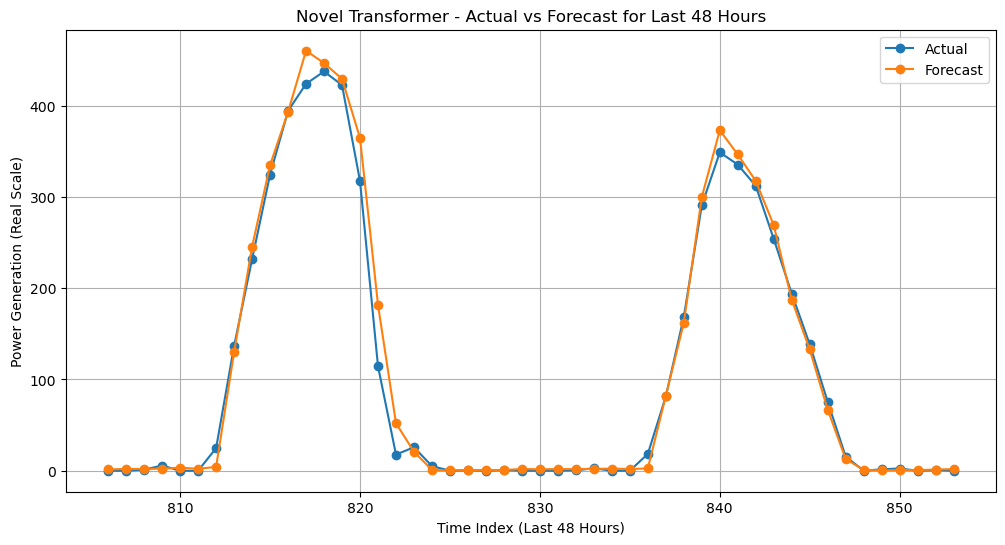

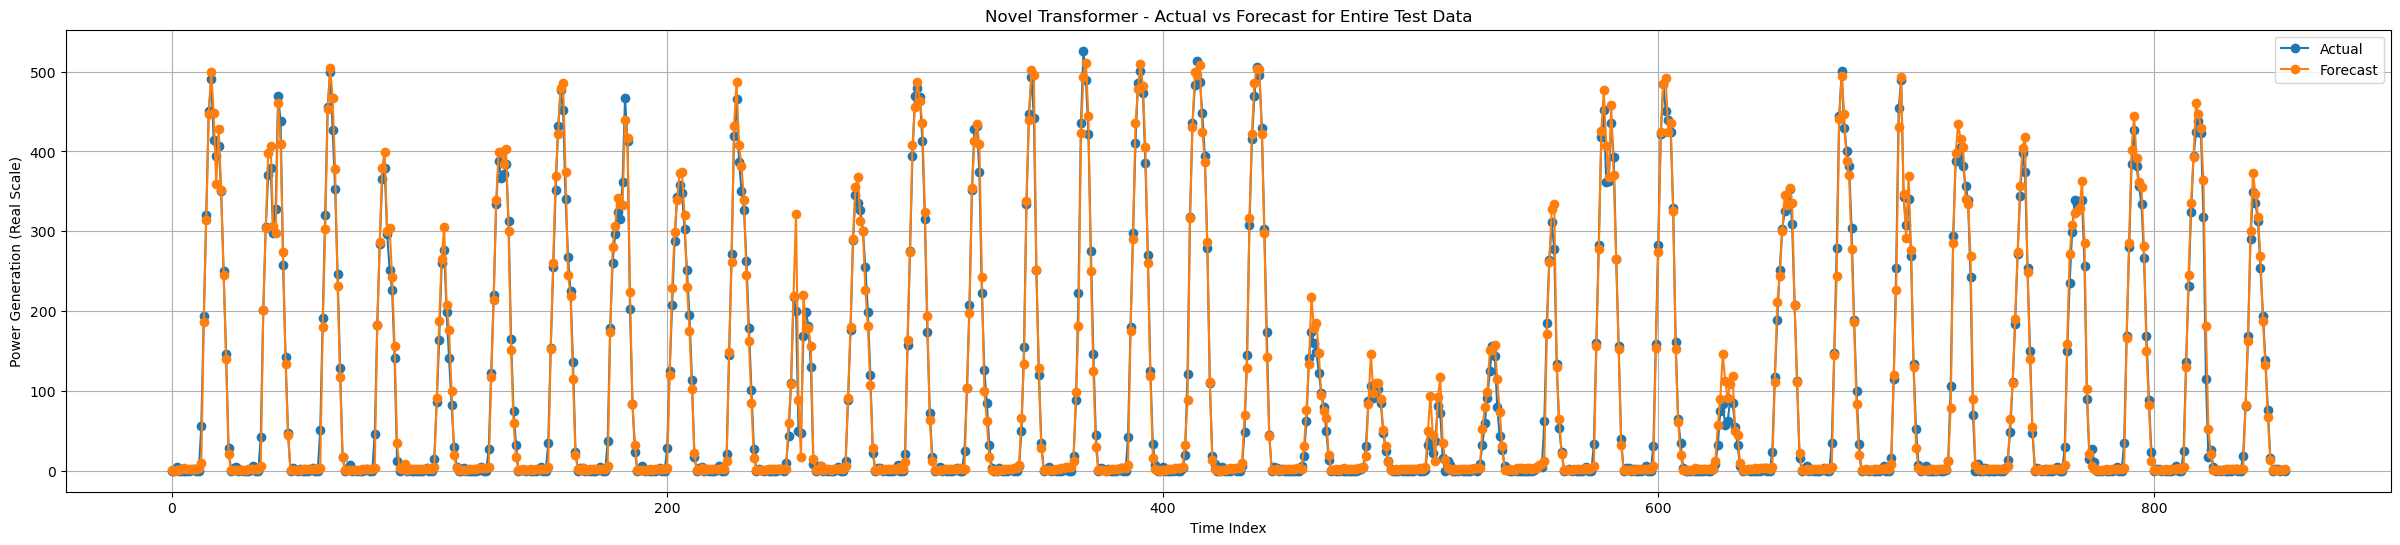

In [28]:
# as numpy arrays with shape (n, 1) from evaluation step.
# flatten them to get 1D arrays.
test_true = test_true_real.flatten()
test_pred = test_pred_real.flatten()


# Plot 1: Last 24 Hours

# Select the last 24 data points
last_48_indices = np.arange(len(test_true) - 48, len(test_true))

plt.figure(figsize=(12, 6))
plt.plot(last_48_indices, test_true[-48:], marker='o', label='Actual')
plt.plot(last_48_indices, test_pred[-48:], marker='o', label='Forecast')
plt.title('Novel Transformer - Actual vs Forecast for Last 48 Hours')
plt.xlabel('Time Index (Last 48 Hours)')
plt.ylabel('Power Generation (Real Scale)')
plt.legend()
plt.grid(True)
plt.show()


# Plot 2: Entire Test Data

plt.figure(figsize=(30, 6))
plt.plot(test_true, marker='o', label='Actual')
plt.plot(test_pred, marker='o', label='Forecast')
plt.title('Novel Transformer - Actual vs Forecast for Entire Test Data')
plt.xlabel('Time Index')
plt.ylabel('Power Generation (Real Scale)')
plt.legend()
plt.grid(True)
plt.show()


In [29]:
# saving predictions of the test set
preds_TF_Modified_test = test_pred 

# Save the predictions to a file
np.save('preds_TF_Modified.npy', preds_TF_Modified_test)

Comparison of All Model Forecasts vs. Actuals Solar Power - Last 48 Hours

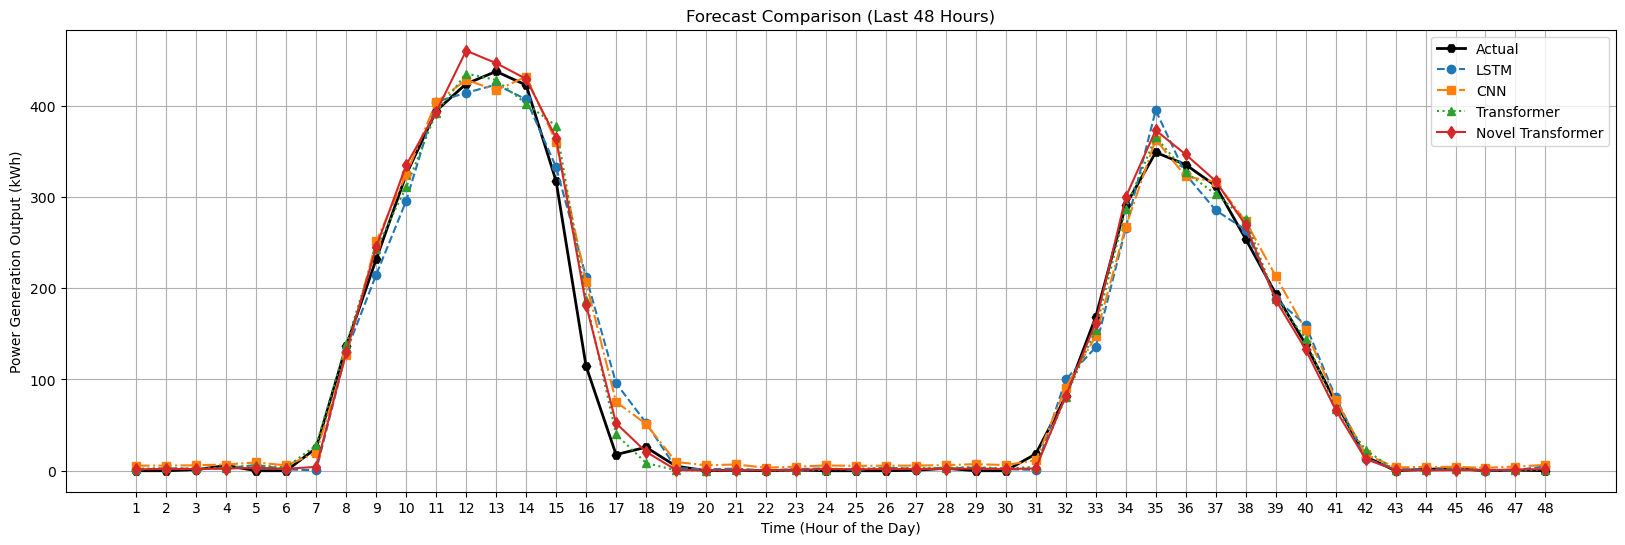

In [30]:
preds_true = np.load('preds_Test_True_.npy')
preds_LSTM_test = np.load('preds_LSTM_.npy')
preds_CNN_test = np.load('preds_CNN_.npy')
preds_TF_test = np.load('preds_TF_.npy')
preds_TF_Modified_test = np.load('preds_TF_Modified.npy')

# Extract the last 48 hours
last_24_actual = preds_true[-48:]
last_24_lstm = preds_LSTM_test[-48:]
last_24_cnn = preds_CNN_test[-48:]
last_24_transformer = preds_TF_test[-48:]
last_24_improved_transformer = preds_TF_Modified_test[-48:]

# Create a time axis for the last 48 hours 
hours = np.arange(1, 49)

plt.figure(figsize=(20,6))
plt.plot(hours, last_24_actual, label="Actual", linewidth=2, color='black', marker='H')
plt.plot(hours, last_24_lstm, label="LSTM", linestyle='--', marker='o')
plt.plot(hours, last_24_cnn, label="CNN", linestyle='-.', marker='s')
plt.plot(hours, last_24_transformer, label="Transformer", linestyle=':', marker='^')
plt.plot(hours, last_24_improved_transformer, label="Novel Transformer", linestyle='-', marker='d')
plt.xlabel("Time (Hour of the Day)")
plt.ylabel("Power Generation Output (kWh)")
plt.title("Forecast Comparison (Last 48 Hours)")
plt.xticks(hours)
plt.legend()
plt.grid(True)
plt.show()


Comparison of All Model Forecasts vs. Actuals Solar Power - Zoomed in Ver. (Last 12 Hours)

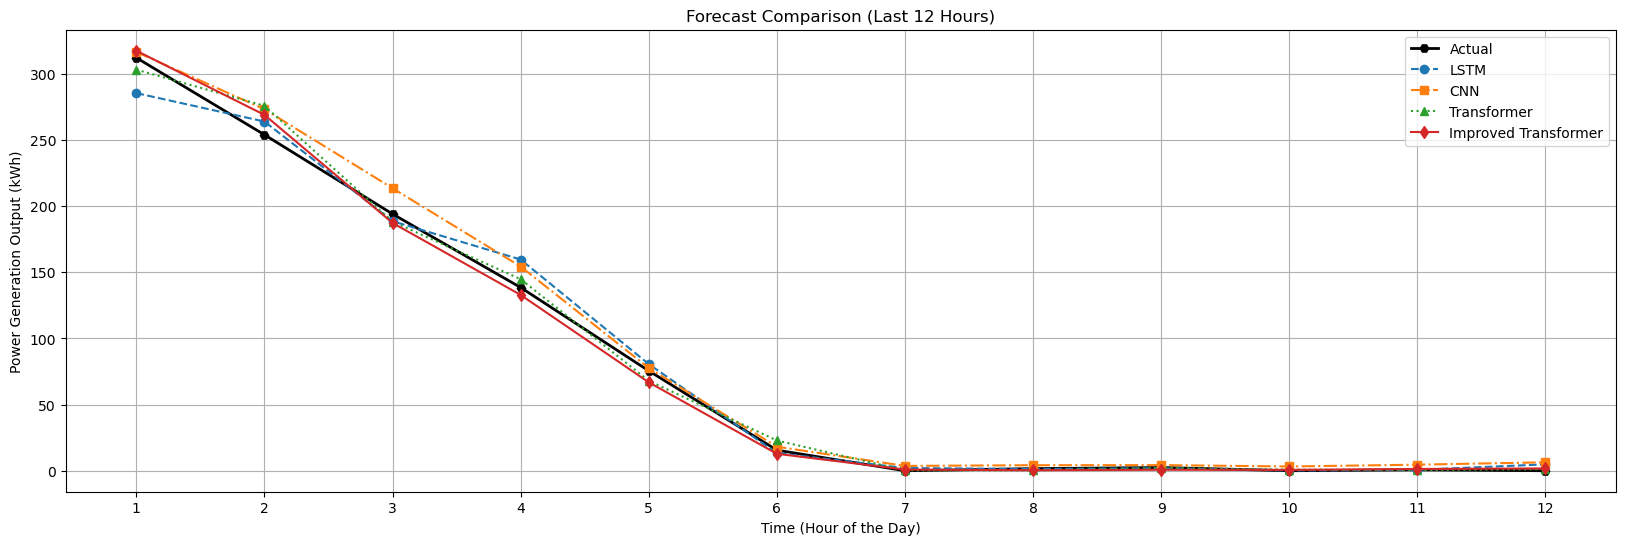

In [31]:
# Extract the last 12 hours
last_12_actual = preds_true[-12:]
last_12_lstm = preds_LSTM_test[-12:]
last_12_cnn = preds_CNN_test[-12:]
last_12_transformer = preds_TF_test[-12:]
last_12_improved_transformer = preds_TF_Modified_test[-12:]

# Create a time axis for the last 12 hours 
hours = np.arange(1, 13)

plt.figure(figsize=(20,6))
plt.plot(hours, last_12_actual, label="Actual", linewidth=2, color='black', marker='H')
plt.plot(hours, last_12_lstm, label="LSTM", linestyle='--', marker='o')
plt.plot(hours, last_12_cnn, label="CNN", linestyle='-.', marker='s')
plt.plot(hours, last_12_transformer, label="Transformer", linestyle=':', marker='^')
plt.plot(hours, last_12_improved_transformer, label="Improved Transformer", linestyle='-', marker='d')
plt.xlabel("Time (Hour of the Day)")
plt.ylabel("Power Generation Output (kWh)")
plt.title("Forecast Comparison (Last 12 Hours)")
plt.xticks(hours)
plt.legend()
plt.grid(True)
plt.show()

Comparison of All Model Forecasts vs. Actuals Solar Power - Zoomed in Ver. (First 7 hours of the last 12 hours)

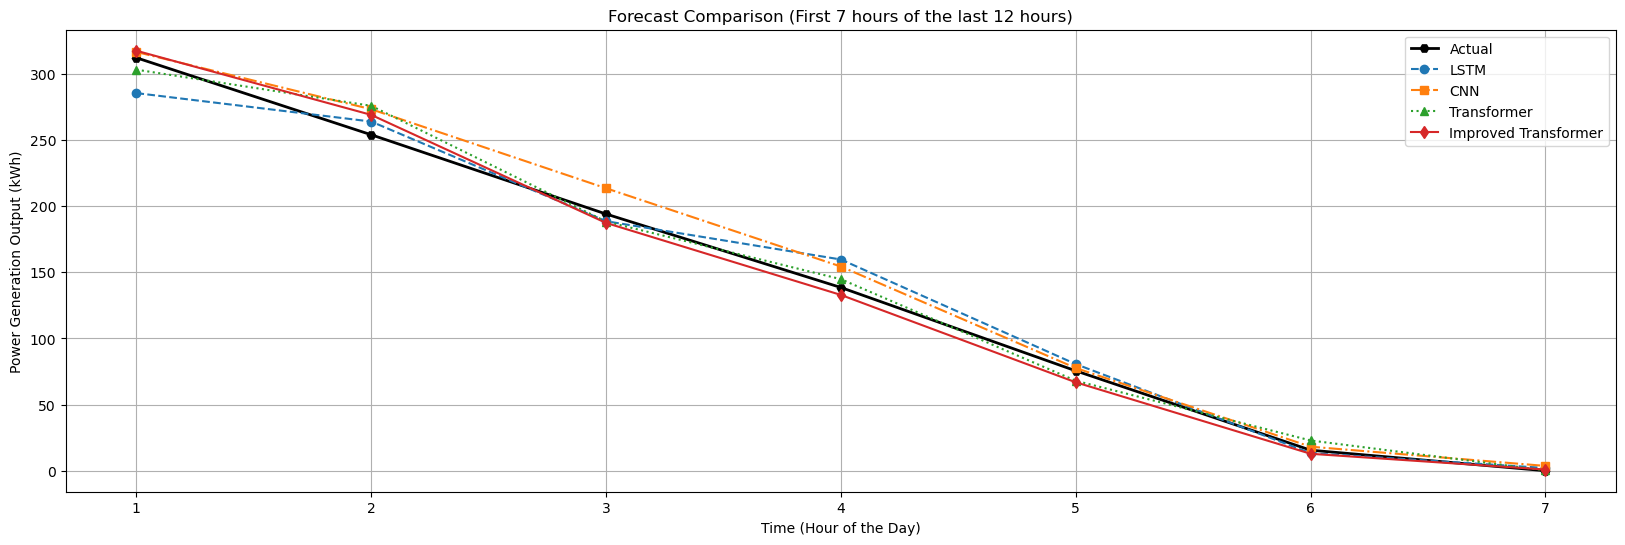

In [32]:
# Extract the first 7 hours of the last 12 hours
last_7_in_12_actual = preds_true[-12:-5]
last_7_in_12_lstm = preds_LSTM_test[-12:-5]
last_7_in_12_cnn = preds_CNN_test[-12:-5]
last_7_in_12_transformer = preds_TF_test[-12:-5]
last_7_in_12_improved_transformer = preds_TF_Modified_test[-12:-5]

# Create a time axis for the 7 hours 
hours = np.arange(1, 8)

plt.figure(figsize=(20,6))
plt.plot(hours, last_7_in_12_actual, label="Actual", linewidth=2, color='black', marker='H')
plt.plot(hours, last_7_in_12_lstm, label="LSTM", linestyle='--', marker='o')
plt.plot(hours, last_7_in_12_cnn, label="CNN", linestyle='-.', marker='s')
plt.plot(hours, last_7_in_12_transformer, label="Transformer", linestyle=':', marker='^')
plt.plot(hours, last_7_in_12_improved_transformer, label="Improved Transformer", linestyle='-', marker='d')
plt.xlabel("Time (Hour of the Day)")
plt.ylabel("Power Generation Output (kWh)")
plt.title("Forecast Comparison (First 7 hours of the last 12 hours)")
plt.xticks(hours)
plt.legend()
plt.grid(True)
plt.show()